In [0]:
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [0]:
os.listdir('/content/drive/My Drive/FACO/respiratory_sound_database')

['Respiratory_Sound_Database']

In [0]:
path ="/content/drive/My Drive/FACO"  
os.chdir(path)
!ls

AIRQUO		      melspectrograms	respiratory_sound_database
demographic_info.txt  model.png		Respiratory_Sound_Database
ESC-50-master	      PDDA_COMPETITION


In [0]:
df_no_diagnosis = pd.read_csv('/content/drive/My Drive/FACO/demographic_info.txt', names = 
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                 delimiter = ' ')

diagnosis = pd.read_csv('/content/drive/My Drive/FACO/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

In [0]:
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

In [0]:
root = '/content/drive/My Drive/FACO/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

In [0]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [0]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head() 

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,192,2b2,Al,mc,LittC2SE
0,191,2b1,Pr,mc,LittC2SE
0,191,2b2,Tc,mc,LittC2SE
0,192,2b1,Al,mc,LittC2SE
0,192,2b3,Ar,mc,LittC2SE


In [0]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [0]:
file_label_df = pd.DataFrame(data = {'filename':filename_list, 'no label':no_label_list, 'crackles only':crack_list, 'wheezes only':wheeze_list, 'crackles and wheezees':both_sym_list})

##Distribution of data classes

In [0]:
w_labels = file_label_df[(file_label_df['crackles only'] != 0) | (file_label_df['wheezes only'] != 0) | (file_label_df['crackles and wheezees'] != 0)]
file_label_df.sum()

filename                 192_2b2_Al_mc_LittC2SE191_2b1_Pr_mc_LittC2SE19...
no label                                                              3642
crackles only                                                         1864
wheezes only                                                           886
crackles and wheezees                                                  506
dtype: object

##Utility functions for reading .wav files (especially pesky 24bit .wav)

In [0]:
import wave
import math
import scipy.io.wavfile as wf
#wave file reader

#Will resample all files to the target sample rate and produce a 32bit float array
def read_wav_file(str_filename, target_rate):
    wav = wave.open(str_filename, mode = 'r')
    (sample_rate, data) = extract2FloatArr(wav,str_filename)
    
    if (sample_rate != target_rate):
        ( _ , data) = resample(sample_rate, data, target_rate)
        
    wav.close()
    return (target_rate, data.astype(np.float32))

def resample(current_rate, data, target_rate):
    x_original = np.linspace(0,100,len(data))
    x_resampled = np.linspace(0,100, int(len(data) * (target_rate / current_rate)))
    resampled = np.interp(x_resampled, x_original, data)
    return (target_rate, resampled.astype(np.float32))

# -> (sample_rate, data)
def extract2FloatArr(lp_wave, str_filename):
    (bps, channels) = bitrate_channels(lp_wave)
    
    if bps in [1,2,4]:
        (rate, data) = wf.read(str_filename)
        divisor_dict = {1:255, 2:32768}
        if bps in [1,2]:
            divisor = divisor_dict[bps]
            data = np.divide(data, float(divisor)) #clamp to [0.0,1.0]        
        return (rate, data)
    
    elif bps == 3: 
        #24bpp wave
        return read24bitwave(lp_wave)
    
    else:
        raise Exception('Unrecognized wave format: {} bytes per sample'.format(bps))
        
#Note: This function truncates the 24 bit samples to 16 bits of precision
#Reads a wave object returned by the wave.read() method
#Returns the sample rate, as well as the audio in the form of a 32 bit float numpy array
#(sample_rate:float, audio_data: float[])
def read24bitwave(lp_wave):
    nFrames = lp_wave.getnframes()
    buf = lp_wave.readframes(nFrames)
    reshaped = np.frombuffer(buf, np.int8).reshape(nFrames,-1)
    short_output = np.empty((nFrames, 2), dtype = np.int8)
    short_output[:,:] = reshaped[:, -2:]
    short_output = short_output.view(np.int16)
    return (lp_wave.getframerate(), np.divide(short_output, 32768).reshape(-1))  #return numpy array to save memory via array slicing

def bitrate_channels(lp_wave):
    bps = (lp_wave.getsampwidth() / lp_wave.getnchannels()) #bytes per sample
    return (bps, lp_wave.getnchannels())

def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

##Distribution of respiratory cycle lengths

longest cycle:16.163
shortest cycle:0.20000000000000284
Fraction of samples less than 5 seconds:0.9660771238040011


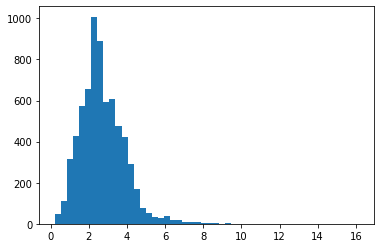

In [0]:
duration_list = []
for i in range(len(rec_annotations)):
    current = rec_annotations[i]
    duration = current['End'] - current['Start']
    duration_list.extend(duration)

duration_list = np.array(duration_list)
plt.hist(duration_list, bins = 50)
print('longest cycle:{}'.format(max(duration_list)))
print('shortest cycle:{}'.format(min(duration_list)))
threshold = 5
print('Fraction of samples less than {} seconds:{}'.format(threshold,
                                                           np.sum(duration_list < threshold)/len(duration_list)))

##Mel spectrogram implementation (With VTLP)

In [0]:
import scipy.signal

#vtlp_params = (alpha, f_high) 
def sample2MelSpectrum(cycle_info, sample_rate, n_filters, vtlp_params):
    n_rows = 175 # 7500 cutoff
    n_window = 512 #~25 ms window
    (f, t, Sxx) = scipy.signal.spectrogram(cycle_info[0],fs = sample_rate, nfft= n_window, nperseg=n_window)
    Sxx = Sxx[:n_rows,:].astype(np.float32) #sift out coefficients above 7500hz, Sxx has 196 columns
    mel_log = FFT2MelSpectrogram(f[:n_rows], Sxx, sample_rate, n_filters, vtlp_params)[1]
    mel_min = np.min(mel_log)
    mel_max = np.max(mel_log)
    diff = mel_max - mel_min
    norm_mel_log = (mel_log - mel_min) / diff if (diff > 0) else np.zeros(shape = (n_filters,Sxx.shape[1]))
    if (diff == 0):
        print('Error: sample data is completely empty')
    labels = [cycle_info[1], cycle_info[2]] #crackles, wheezes flags
    return (np.reshape(norm_mel_log, (n_filters,Sxx.shape[1],1)).astype(np.float32), # 196x64x1 matrix
            label2onehot(labels)) 
        
def Freq2Mel(freq):
    return 1125 * np.log(1 + freq / 700)

def Mel2Freq(mel):
    exponents = mel / 1125
    return 700 * (np.exp(exponents) - 1)

#Tased on Jaitly & Hinton(2013)
#Takes an array of the original mel spaced frequencies and returns a warped version of them
def VTLP_shift(mel_freq, alpha, f_high, sample_rate):
    nyquist_f = sample_rate / 2
    warp_factor = min(alpha, 1)
    threshold_freq = f_high * warp_factor / alpha
    lower = mel_freq * alpha
    higher = nyquist_f - (nyquist_f - mel_freq) * ((nyquist_f - f_high * warp_factor) / (nyquist_f - f_high * (warp_factor / alpha)))
    
    warped_mel = np.where(mel_freq <= threshold_freq, lower, higher)
    return warped_mel.astype(np.float32)

#mel_space_freq: the mel frequencies (HZ) of the filter banks, in addition to the two maximum and minimum frequency values
#fft_bin_frequencies: the bin freqencies of the FFT output
#Generates a 2d numpy array, with each row containing each filter bank
def GenerateMelFilterBanks(mel_space_freq, fft_bin_frequencies):
    n_filters = len(mel_space_freq) - 2
    coeff = []
    #Triangular filter windows
    #ripped from http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
    for mel_index in range(n_filters):
        m = int(mel_index + 1)
        filter_bank = []
        for f in fft_bin_frequencies:
            if(f < mel_space_freq[m-1]):
                hm = 0
            elif(f < mel_space_freq[m]):
                hm = (f - mel_space_freq[m-1]) / (mel_space_freq[m] - mel_space_freq[m-1])
            elif(f < mel_space_freq[m + 1]):
                hm = (mel_space_freq[m+1] - f) / (mel_space_freq[m + 1] - mel_space_freq[m])
            else:
                hm = 0
            filter_bank.append(hm)
        coeff.append(filter_bank)
    return np.array(coeff, dtype = np.float32)
        
#Transform spectrogram into mel spectrogram -> (frequencies, spectrum)
#vtlp_params = (alpha, f_high), vtlp will not be applied if set to None
def FFT2MelSpectrogram(f, Sxx, sample_rate, n_filterbanks, vtlp_params = None):
    (max_mel, min_mel)  = (Freq2Mel(max(f)), Freq2Mel(min(f)))
    mel_bins = np.linspace(min_mel, max_mel, num = (n_filterbanks + 2))
    #Convert mel_bins to corresponding frequencies in hz
    mel_freq = Mel2Freq(mel_bins)
    
    if(vtlp_params is None):
        filter_banks = GenerateMelFilterBanks(mel_freq, f)
    else:
        #Apply VTLP
        (alpha, f_high) = vtlp_params
        warped_mel = VTLP_shift(mel_freq, alpha, f_high, sample_rate)
        filter_banks = GenerateMelFilterBanks(warped_mel, f)
        
    mel_spectrum = np.matmul(filter_banks, Sxx)
    return (mel_freq[1:-1], np.log10(mel_spectrum  + float(10e-12)))
    
#labels proved too difficult to train (model keep convergining to statistical mean)
#Flattened to onehot labels since the number of combinations is very low
def label2onehot(c_w_flags):
    c = c_w_flags[0]
    w = c_w_flags[1]
    if((c == False) & (w == False)):
        return [1,0,0,0]
    elif((c == True) & (w == False)):
        return [0,1,0,0]
    elif((c == False) & (w == True)):
        return [0,0,1,0]
    else:
        return [0,0,0,1]


###Data preparation utility functions

In [0]:
#Used to split each individual sound file into separate sound clips containing one respiratory cycle each
#output: [filename, (sample_data:np.array, start:float, end:float, crackles:bool(float), wheezes:bool(float)) (...) ]
def get_sound_samples(recording_annotations, file_name, root, sample_rate):
    sample_data = [file_name]
    (rate, data) = read_wav_file(os.path.join(root, file_name + '.wav'), sample_rate)
    
    for i in range(len(recording_annotations.index)):
        row = recording_annotations.loc[i]
        start = row['Start']
        end = row['End']
        crackles = row['Crackles']
        wheezes = row['Wheezes']
        audio_chunk = slice_data(start, end, data, rate)
        sample_data.append((audio_chunk, start,end,crackles,wheezes))
    return sample_data

#Fits each respiratory cycle into a fixed length audio clip, splits may be performed and zero padding is added if necessary
#original:(arr,c,w) -> output:[(arr,c,w),(arr,c,w)]
def split_and_pad(original, desiredLength, sampleRate):
    output_buffer_length = int(desiredLength * sampleRate)
    soundclip = original[0]
    n_samples = len(soundclip)
    total_length = n_samples / sampleRate #length of cycle in seconds
    n_slices = int(math.ceil(total_length / desiredLength)) #get the minimum number of slices needed
    samples_per_slice = n_samples // n_slices
    src_start = 0 #Staring index of the samples to copy from the original buffer
    output = [] #Holds the resultant slices
    for i in range(n_slices):
        src_end = min(src_start + samples_per_slice, n_samples)
        length = src_end - src_start
        copy = generate_padded_samples(soundclip[src_start:src_end], output_buffer_length)
        output.append((copy, original[1], original[2]))
        src_start += length
    return output

def generate_padded_samples(source, output_length):
    copy = np.zeros(output_length, dtype = np.float32)
    src_length = len(source)
    frac = src_length / output_length
    if(frac < 0.5):
        #tile forward sounds to fill empty space
        cursor = 0
        while(cursor + src_length) < output_length:
            copy[cursor:(cursor + src_length)] = source[:]
            cursor += src_length
    else:
        copy[:src_length] = source[:]
    #
    return copy

##Data augmentation
Two basic forms employed : audio stretching (speeding up or down) as well as Vocal Tract Length perturbation

In [0]:
#Creates a copy of each time slice, but stretches or contracts it by a random amount
def gen_time_stretch(original, sample_rate, max_percent_change):
    stretch_amount = 1 + np.random.uniform(-1,1) * (max_percent_change / 100)
    (_, stretched) = resample(sample_rate, original, int(sample_rate * stretch_amount)) 
    return stretched

#Same as above, but applies it to a list of samples
def augment_list(audio_with_labels, sample_rate, percent_change, n_repeats):
    augmented_samples = []
    for i in range(n_repeats):
        addition = [(gen_time_stretch(t[0], sample_rate, percent_change), t[1], t[2] ) for t in audio_with_labels]
        augmented_samples.extend(addition)
    return augmented_samples

#Takes a list of respiratory cycles, and splits and pads each cycle into fixed length buffers (determined by desiredLength(seconds))
#Then takes the split and padded sample and transforms it into a mel spectrogram
#VTLP_alpha_range = [Lower, Upper] (Bounds of random selection range), 
#VTLP_high_freq_range = [Lower, Upper] (-)
#output:[(arr:float[],c:float_bool,w:float_bool),(arr,c,w)]
def split_and_pad_and_apply_mel_spect(original, desiredLength, sampleRate, VTLP_alpha_range = None, VTLP_high_freq_range = None, n_repeats = 1):
    output = []
    for i in range(n_repeats):
        for d in original:
            lst_result = split_and_pad(d, desiredLength, sampleRate) #Time domain
            if( (VTLP_alpha_range is None) | (VTLP_high_freq_range is None) ):
                #Do not apply VTLP
                VTLP_params = None
            else:
                #Randomly generate VLTP parameters
                alpha = np.random.uniform(VTLP_alpha_range[0], VTLP_alpha_range[1])
                high_freq = np.random.uniform(VTLP_high_freq_range[0], VTLP_high_freq_range[1])
                VTLP_params = (alpha, high_freq)
            freq_result = [sample2MelSpectrum(d, sampleRate, 50, VTLP_params) for d in lst_result] #Freq domain
            output.extend(freq_result)
    return output

163


Text(0.5, 1.0, 'With VTLP')

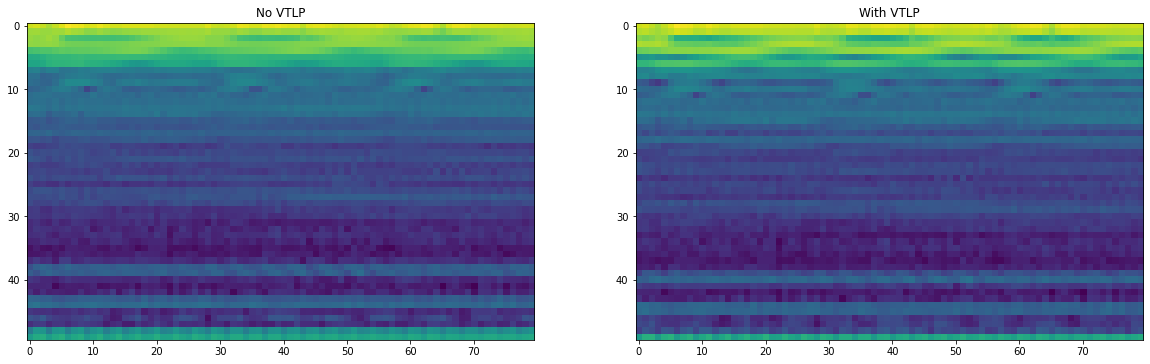

In [0]:
str_file = filenames[11]
lp_test = get_sound_samples(rec_annotations_dict[str_file], str_file, root, 22000)
lp_cycles = [(d[0], d[3], d[4]) for d in lp_test[1:]]
soundclip = lp_cycles[1][0]

n_window = 512
sample_rate = 22000
(f, t, Sxx) = scipy.signal.spectrogram(soundclip, fs = 22000, nfft= n_window, nperseg=n_window)
print(sum(f < 7000))

plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
mel_banks = FFT2MelSpectrogram(f[:175], Sxx[:175,:], sample_rate, 50)[1]
plt.imshow(mel_banks, aspect = 1)
plt.title('No VTLP')

plt.subplot(1,2,2)
mel_banks = FFT2MelSpectrogram(f[:175], Sxx[:175,:], sample_rate, 50, vtlp_params = (0.9,3500))[1]
plt.imshow(mel_banks, aspect = 1)
plt.title('With VTLP')

##Utility used to import all training samples

In [0]:
from sklearn.model_selection import train_test_split

def extract_all_training_samples(filenames, annotation_dict, root, target_rate, desired_length, train_test_ratio = 0.2):
    cycle_list = []
    for file in filenames:
        data = get_sound_samples(annotation_dict[file], file, root, target_rate)
        cycles_with_labels = [(d[0], d[3], d[4]) for d in data[1:]]
        cycle_list.extend(cycles_with_labels)
    
    #Sort into respective classes
    no_labels = [c for c in cycle_list if ((c[1] == 0) & (c[2] == 0))]
    c_only = [c for c in cycle_list if ((c[1] == 1) & (c[2] == 0))] 
    w_only = [c for c in cycle_list if ((c[1] == 0) & (c[2] == 1))]
    c_w = [c for c in cycle_list if ((c[1] == 1) & (c[2] == 1))]
    
    #Count of labels across all cycles, actual recording time also follows similar ratios
    #none:3642
    #crackles:1864 
    #wheezes:886
    #both:506
    none_train, none_test = train_test_split(no_labels, test_size = train_test_ratio)
    c_train, c_test  = train_test_split(c_only, test_size = train_test_ratio)
    w_train, w_test  = train_test_split(w_only, test_size = train_test_ratio)
    c_w_train, c_w_test  = train_test_split(c_w, test_size = train_test_ratio)
    
    #Training section (Data augmentation procedures)
    #Augment w_only and c_w groups to match the size of c_only
    #no_labels will be artifically reduced in the pipeline  later
    w_stretch = w_train + augment_list(w_train, target_rate, 10 , 1) #
    c_w_stretch = c_w_train + augment_list(c_w_train , target_rate, 10 , 1) 
    
    #Split up cycles into sound clips with fixed lengths so they can be fed into a CNN
    vtlp_alpha = [0.9,1.1]
    vtlp_upper_freq = [3200,3800]
    
    train_none  = (split_and_pad_and_apply_mel_spect(none_train, desired_length, target_rate) +
                   split_and_pad_and_apply_mel_spect(none_train, desired_length, target_rate, vtlp_alpha))
    
    train_c = (split_and_pad_and_apply_mel_spect(c_train, desired_length, target_rate) + 
               split_and_pad_and_apply_mel_spect(c_train, desired_length, target_rate, vtlp_alpha, vtlp_upper_freq, n_repeats = 3) ) #original samples + VTLP
    
    train_w = (split_and_pad_and_apply_mel_spect(w_stretch, desired_length, target_rate) + 
               split_and_pad_and_apply_mel_spect(w_stretch , desired_length, target_rate, vtlp_alpha , vtlp_upper_freq, n_repeats = 4)) #(original samples + time stretch) + VTLP
    
    train_c_w = (split_and_pad_and_apply_mel_spect(c_w_stretch, desired_length, target_rate) + 
                 split_and_pad_and_apply_mel_spect(c_w_stretch, desired_length, target_rate, vtlp_alpha , vtlp_upper_freq, n_repeats = 7)) #(original samples + time stretch * 2) + VTLP
    
    train_dict = {'none':train_none,'crackles':train_c,'wheezes':train_w, 'both':train_c_w}
    
    #test section 
    test_none  = split_and_pad_and_apply_mel_spect(none_test, desired_length, target_rate)
    test_c = split_and_pad_and_apply_mel_spect(c_test, desired_length, target_rate)
    test_w = split_and_pad_and_apply_mel_spect(w_test, desired_length, target_rate)
    test_c_w = split_and_pad_and_apply_mel_spect(c_w_test, desired_length, target_rate)
    
    test_dict = {'none':test_none,'crackles':test_c,'wheezes':test_w, 'both':test_c_w}
    
    return [train_dict, test_dict]
    

In [0]:
target_sample_rate = 22000 
sample_length_seconds = 5
sample_dict = extract_all_training_samples(filenames, rec_annotations_dict, root, target_sample_rate, sample_length_seconds) #sample rate lowered to meet memory constraints
training_clips = sample_dict[0]
test_clips = sample_dict[1]

In [0]:
def print_sample_count(src_dict):
    print('none:{}\ncrackles:{}\nwheezes:{}\nboth:{}'.format(len(src_dict['none']),
                                                        len(src_dict['crackles']),
                                                        len(src_dict['wheezes']),
                                                        len(src_dict['both'])))

print('Samples Available')
print('[Training set]')
print_sample_count(training_clips)
print('')
print('[Test set]')
print_sample_count(test_clips)

Samples Available
[Training set]
none:6086
crackles:6040
wheezes:7245
both:6808

[Test set]
none:760
crackles:378
wheezes:185
both:106


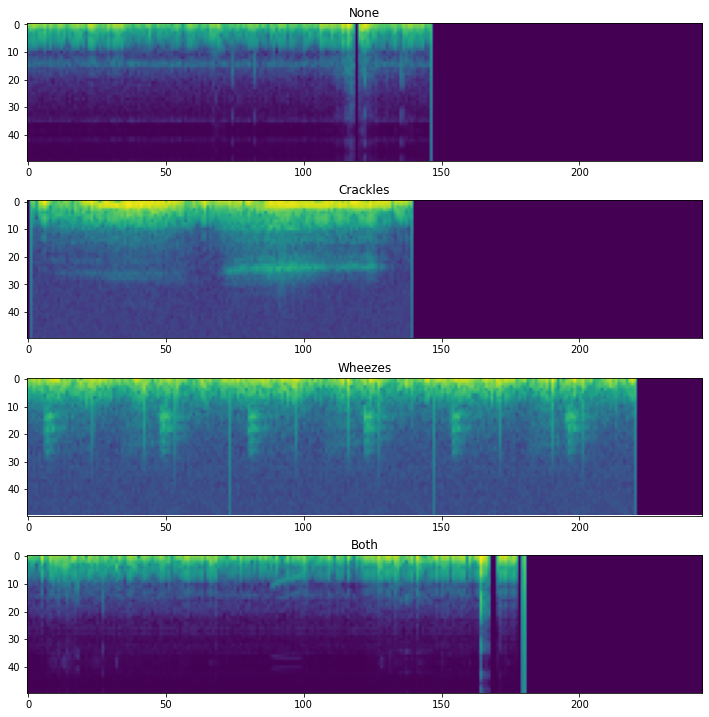

In [0]:
#Example of tiled sound samples
sample_height = training_clips['none'][0][0].shape[0]
sample_width = training_clips['none'][0][0].shape[1]
ind = 1
plt.figure(figsize = (10,10))
plt.subplot(4,1,1)
plt.imshow(training_clips['none'][ind][0].reshape(sample_height, sample_width))
plt.title('None')
plt.subplot(4,1,2)
plt.imshow(training_clips['crackles'][ind][0].reshape(sample_height, sample_width))
plt.title('Crackles')
plt.subplot(4,1,3)
plt.imshow(training_clips['wheezes'][ind][0].reshape(sample_height, sample_width))
plt.title('Wheezes')
plt.subplot(4,1,4)
plt.imshow(training_clips['both'][ind][0].reshape(sample_height, sample_width))
plt.title('Both')
plt.tight_layout()

###Data Pipeline

In [0]:
import scipy.signal

#Interleaved sampling between classes
#Used to ensure a balance of classes for the training set
class data_generator():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, strides):
        self.clips = sound_clips
        self.strides = strides
        self.lengths = [len(arr) for arr in sound_clips]
    
    def n_available_samples(self):
        return int(min(np.divide(self.lengths, self.strides))) * 4
    
    def generate_keras(self, batch_size):
        cursor = [0,0,0,0]
        while True:
            i = 0
            X,y = [],[]
            for c in range(batch_size):
                cat_length = self.lengths[i]
                cat_clips = self.clips[i]
                cat_stride = self.strides[i]
                cat_advance = np.random.randint(low= 1,high = cat_stride + 1)
                clip = cat_clips[(cursor[i] + cat_advance) % cat_length]
                cursor[i] = (cursor[i] + self.strides[i]) % cat_length #advance cursor
                s = (self.rollFFT(clip))
                X.append(s[0])
                y.append(s[1])
                i = (i + 1) % 4 # go to next class
            yield (np.reshape(X, (batch_size, sample_height, sample_width, 1)),
                   np.reshape(y,(batch_size,4)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

#Used for validation set
class feed_all():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, roll = True):
        merged = []
        for arr in sound_clips:
            merged.extend(arr)
        np.random.shuffle(merged)
        self.clips = merged
        self.nclips = len(merged)
        self.roll = roll
    
    def n_available_samples(self):
        return len(self.clips)
    
    def generate_keras(self, batch_size):
        i = 0
        while True:
            X,y = [],[]
            for b in range(batch_size):
                clip = self.clips[i]
                i = (i + 1) % self.nclips
                if(self.roll):
                    s = (self.rollFFT(clip))
                    X.append(s[0])
                    y.append(s[1])
                else:
                    X.append(clip[0])
                    y.append(clip[1])
                    
            yield (np.reshape(X, (batch_size,sample_height, sample_width,1)),
                   np.reshape(y,(batch_size, 4)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])


In [0]:
[none_train, c_train, w_train, c_w_train] = [training_clips['none'], training_clips['crackles'], training_clips['wheezes'], training_clips['both']]
[none_test, c_test, w_test,c_w_test] =  [test_clips['none'], test_clips['crackles'], test_clips['wheezes'], test_clips['both']]

np.random.shuffle(none_train)
np.random.shuffle(c_train)
np.random.shuffle(w_train)
np.random.shuffle(c_w_train)

#Data pipeline objects
train_gen = data_generator([none_train, c_train, w_train, c_w_train], [1,1,1,1])
test_gen = feed_all([none_test, c_test, w_test,c_w_test])

###CNN implementation

In [0]:
batch_size = 128
n_epoch = 15

In [0]:
#Keras implementation
from keras import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Conv2D, Dense, Activation, Dropout, MaxPool2D, Flatten, LeakyReLU
import tensorflow as tf
K.clear_session()

model = Sequential()
model.add(Conv2D(128, [7,11], strides = [2,2], padding = 'SAME', input_shape = (sample_height, sample_width, 1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [5,5], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [1,1], padding = 'SAME'))
model.add(Conv2D(256, [3,3], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(512, [1,1], padding = 'SAME'))
model.add(Conv2D(512, [3,3], padding = 'SAME',activation = 'relu'))
model.add(Conv2D(512, [1,1], padding = 'SAME'))
model.add(Conv2D(512, [3,3], padding = 'SAME', activation = 'relu'))
model.add(MaxPool2D(padding = 'SAME'))
model.add(Flatten())

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(512, activation = 'relu'))
model.add(Dense(4, activation = 'softmax'))

opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)

model.compile(optimizer =  opt , loss = 'categorical_crossentropy', metrics = ['acc'])


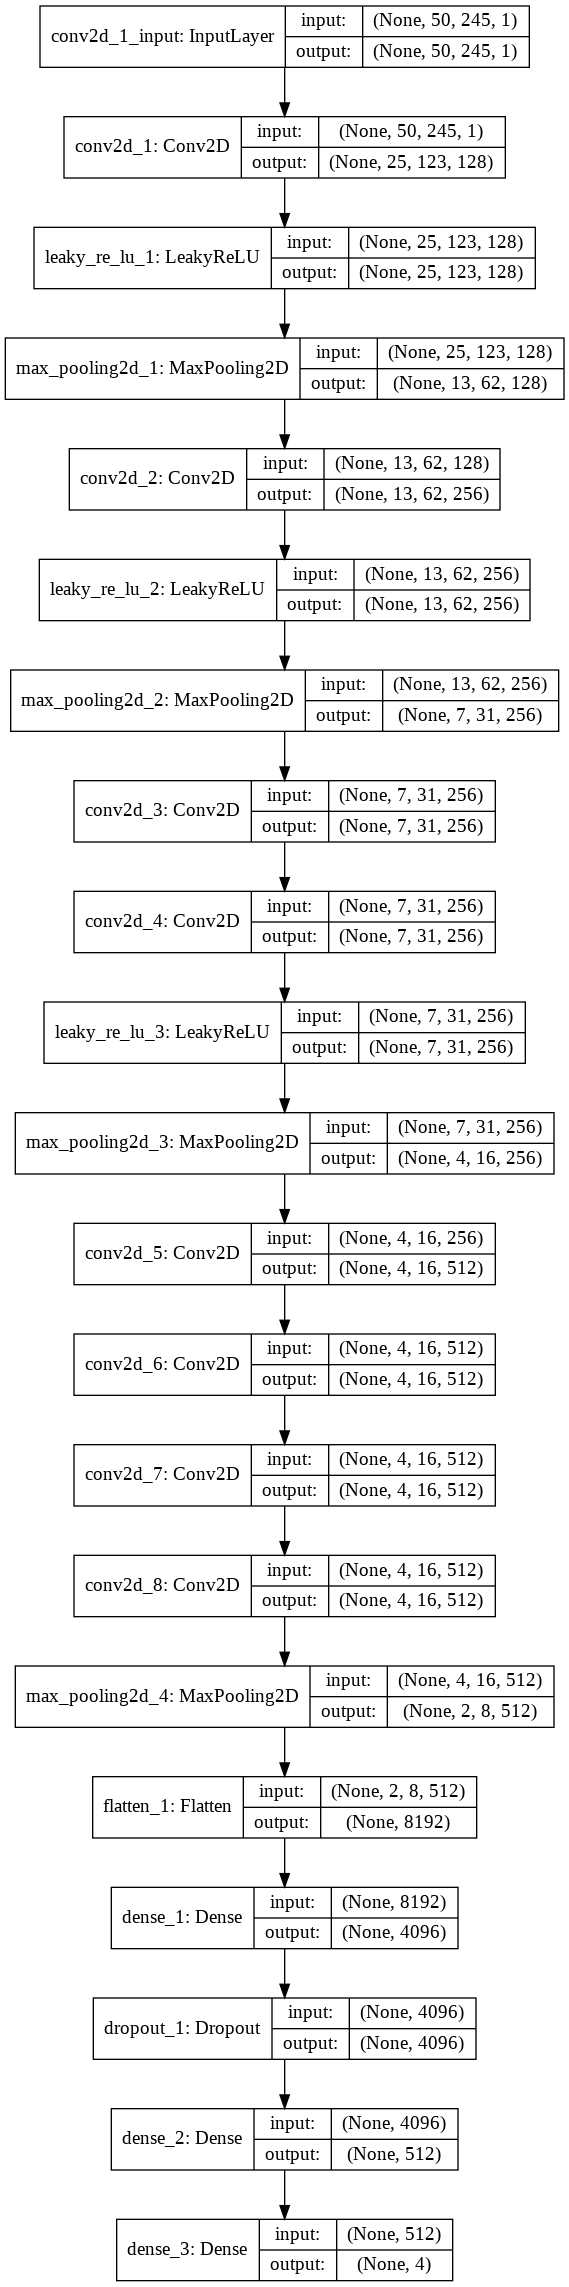

In [0]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names = True)
from IPython.display import Image
Image(filename='model.png')

In [0]:
stats = model.fit_generator(generator = train_gen.generate_keras(batch_size), 
                    steps_per_epoch = train_gen.n_available_samples() // batch_size,  
        epochs = n_epoch,
        validation_data = test_gen.generate_keras(batch_size),
        validation_steps = test_gen.n_available_samples() // batch_size
        )                   

ValueError: ignored